In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning

I am going to split the genres column into their individual columns to make the data easier to work with. I'll use one hot coding to mark each column with either a 1 or a 0 if the movie includes that genre. I will then join the ratings and the movies datasets so that we have a dataset that can match the movie name to the rating for each user. 

In [27]:
df_movies = pd.read_csv('data/movies.csv')
df_ratings = pd.read_csv('data/ratings.csv')
df_links = pd.read_csv('data/links.csv')
df_tags = pd.read_csv('data/tags.csv')

df_movies['genres'] = df_movies['genres'].str.split('|')
df_genres = df_movies['genres'].str.join('|').str.get_dummies(sep='|')

df_movies = pd.concat([df_movies, df_genres], axis=1)

df_movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_movie_ratings = pd.merge(df_ratings, df_movies, how = 'inner', on = 'movieId')

df_movie_ratings = df_movie_ratings.drop('genres', axis=1)

df_movie_ratings.head()


,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,847434962,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,1106635946,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,1510577970,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,1305696483,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

In [29]:
num_users = df_movie_ratings['userId'].nunique()
num_movies = df_movie_ratings['movieId'].nunique()
num_ratings = df_movie_ratings['rating'].count()

print(f"Number of unique users in the dataset: {num_users}")
print(f"Number of unique movies in the dataset: {num_movies}")
print(f"Number of ratings in the dataset: {num_ratings}")

Number of unique users in the dataset: 610
Number of unique movies in the dataset: 9724
Number of ratings in the dataset: 100836


I first took a look at a overall statistics of the dataset I'm using. Based on these numbers, there are more than 15 times more movies than users and there are 10 times more ratings. This indicates that I have a lot of data to work with and plan to thouroughly explore and understand what my data looks like before I make the recommender system. Now I want to take a look at the ratings and their distribution.

In [30]:
rating_counts = df_movie_ratings['rating'].value_counts().reset_index()
rating_counts = rating_counts.sort_values(by = "rating")
rating_counts

,rating,count
9,0.5,1370
7,1.0,2811
8,1.5,1791
5,2.0,7551
6,2.5,5550
1,3.0,20047
3,3.5,13136
0,4.0,26818
4,4.5,8551
2,5.0,13211


Based on this table, we can see that ratings of 3 to 5 occur at the highest frequency. Let's visualize that in a bar chart. 

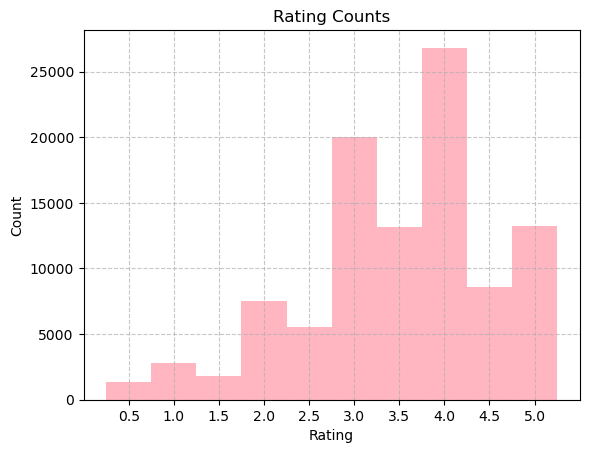

In [31]:
plt.bar(rating_counts['rating'], rating_counts['count'], color='lightpink', width = 0.5)
plt.xticks(rating_counts['rating'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Counts')
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.grid(axis='x', linestyle='--', alpha=0.7) 

Taking a look at this bar chart, it confirms my initial assumption. Most of the ratings in this dataset are high, so we may need to adjust our system to account for this. 

Next, I want to look at the distribution of movie ratings by user.

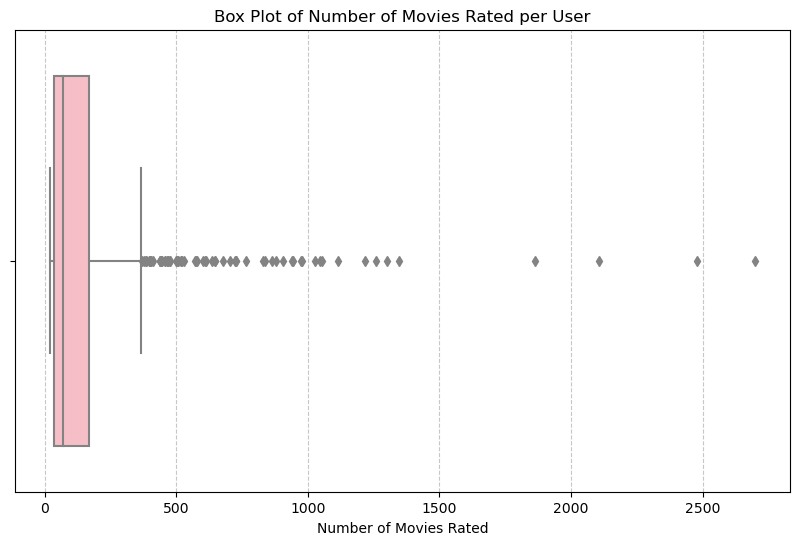

In [32]:
df_users_and_movies = df_movie_ratings[['userId', 'movieId']]

movies_per_user = df_users_and_movies['userId'].value_counts().reset_index()

movies_per_user.columns = ['UserId', 'Number of Movies Rated']

movies_per_user = movies_per_user.sort_values(by='UserId')

plt.figure(figsize=(10, 6))
sns.boxplot(x=movies_per_user['Number of Movies Rated'], color='lightpink')
plt.xlabel('Number of Movies Rated')
plt.title('Box Plot of Number of Movies Rated per User')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


This figure was hard to read because a majority of users have very few ratings but the outliers make the figure hard to read. So, I will temporarily remove the outliers using the interquartile range. 

In [33]:
## remove outliers

Q1 = movies_per_user['Number of Movies Rated'].quantile(0.25)
Q3 = movies_per_user['Number of Movies Rated'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_movies_per_user = movies_per_user[(movies_per_user['Number of Movies Rated'] >= lower_bound) & (movies_per_user['Number of Movies Rated'] <= upper_bound)]
 
print(filtered_movies_per_user)


     UserId  Number of Movies Rated
112       1                     232
501       2                      29
430       3                      39
121       4                     216
409       5                      44
..      ...                     ...
190     602                     135
247     604                     100
119     605                     221
140     607                     187
441     609                      37

[540 rows x 2 columns]


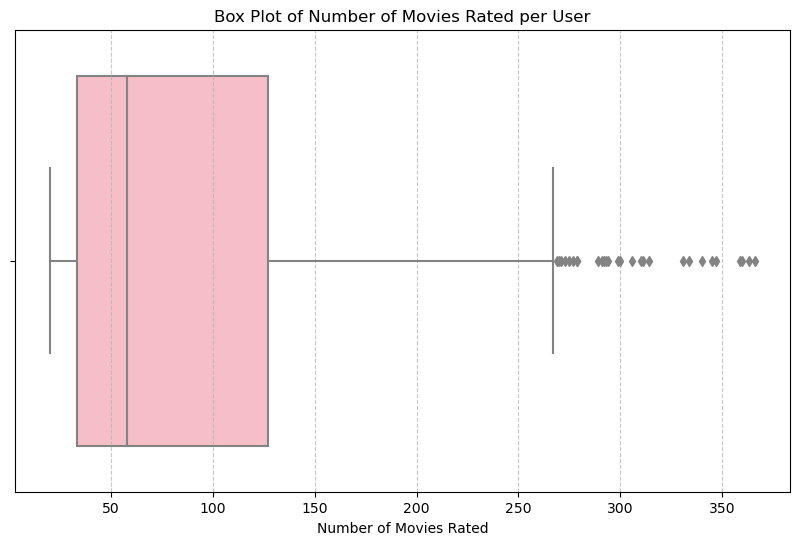

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_movies_per_user['Number of Movies Rated'], color='lightpink')
plt.xlabel('Number of Movies Rated')
plt.title('Box Plot of Number of Movies Rated per User')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

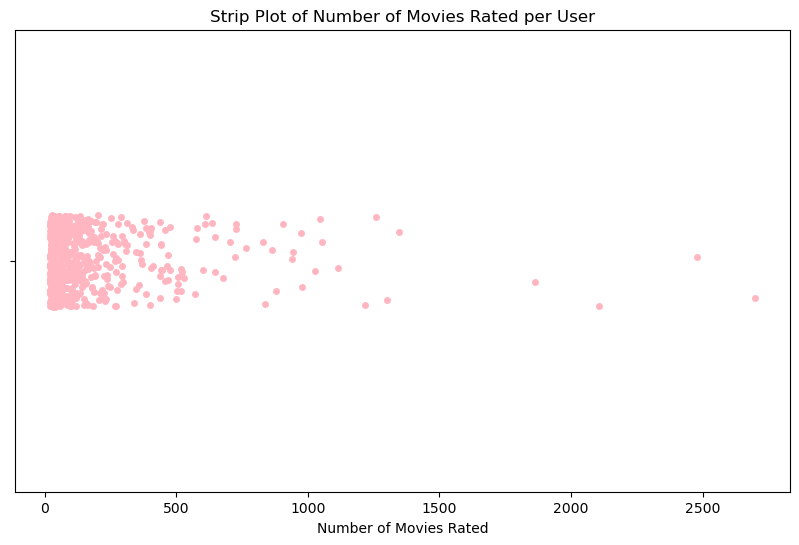

In [35]:
plt.figure(figsize=(10,6))
sns.stripplot(x=movies_per_user['Number of Movies Rated'], color='lightpink')
plt.xlabel('Number of Movies Rated')
plt.title('Strip Plot of Number of Movies Rated per User')
plt.show()

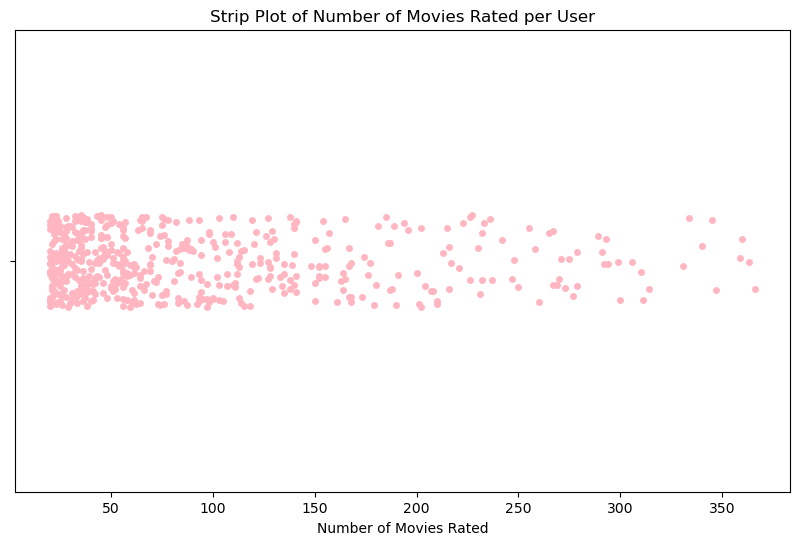

In [36]:
plt.figure(figsize=(10,6))
sns.stripplot(x=filtered_movies_per_user['Number of Movies Rated'], color='lightpink')
plt.xlabel('Number of Movies Rated')
plt.title('Strip Plot of Number of Movies Rated per User')
plt.show()

In [ ]:
genre_counts = df_movies.iloc[:, 3:].sum().sort_values(ascending=False)

print(df_movies.iloc[:, 3:].dtypes)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Genres')
plt.show()

In [ ]:
df_movies_and_ratings = df_movie_ratings[['title', 'ratings']]

ratings_per_movie = df_movies_and_ratings['title'].value_counts().reset_index()

movies_per_user.columns = ['Movie Title', 'Number of Ratings']

movies_per_user = movies_per_user.sort_values(by='title')

df_movie_ratings_grouped = df_movie_ratings.groupby('title')['ratings'].mean()

df_movie_ratings_grouped